# Filtering and Trimming Messages

In real-time chatbot development, its important to keep a track of all the conversation, so it adds more context to the users having interaction with the chatbot. 

But there are cases these message gets stacked up together, and if the message content is more then it going to increase the latency, tokens cost, etc. 

To avoid all such scenarios, we can try to employ two techniques: Filtering or Trimming the messages.

## Loading Environment Variables

In [4]:
from dotenv import load_dotenv
_ = load_dotenv()

## Initializing LLM

In [5]:
from langgraph.graph import START, END, StateGraph, MessagesState
from langchain_groq import ChatGroq
from langchain_core.messages import AIMessage, HumanMessage, RemoveMessage

# Initialize the Groq chat model
llm = ChatGroq(model="qwen/qwen3-32b")
llm.invoke("Hello World!")

AIMessage(content='<think>\nOkay, the user just said "Hello World!" so I need to respond appropriately. Let me think about the best way to reply.\n\nFirst, "Hello World!" is a common greeting, often used as a starting point in programming. Maybe the user is testing the waters or just being friendly. I should acknowledge their message warmly.\n\nI should make sure my response is welcoming and open-ended. Let them know I\'m here to help with any questions they might have. Something like "Hello! How can I assist you today?" That should cover it.\n\nWait, maybe add an emoji to keep it friendly. A smiley face would work. Also, keep the tone conversational, not too formal. Yeah, that should do it. Let me put it all together.\n</think>\n\nHello! 😊 How can I assist you today? Whether you have a question, need help with something, or just want to chat, I\'m here for you!', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 193, 'prompt_tokens': 11, 'total_tokens': 204

## Building Simple Chatbot Graph

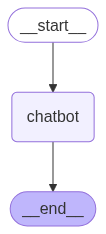

In [6]:
def chatbot(state: MessagesState): 
    return {"messages" : [llm.invoke(state["messages"])]}

# building and compiling graph
builder = StateGraph(MessagesState)

builder.add_node("chatbot", chatbot)

builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

graph = builder.compile()

graph

In [7]:
response = graph.invoke({"messages" : [HumanMessage("Hello, how are you?")]})

for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hello, how are you?
================================== Ai Message ==================================

<think>
Okay, the user is asking how I am. I need to respond with a friendly and positive message.

I should acknowledge their greeting and express that I'm doing well. 

Adding an emoji like 😊 or 🌟 would make the response more engaging and warm.

I should also ask how they're doing to keep the conversation going.

Let me make sure the tone stays cheerful and approachable.
</think>

Hello! I'm doing great, thank you! 😊 How about you? I'd love to hear how you're feeling today! 🌟


## Filtering Messages

As we notice above, if we include memory in our graph then as the conversation gets increased the number of messages gets increased along with the the number of tokens which is not recommended and also increases the token size and increaes the latency. 

## Case - 1: Modifying messages data in Original State

In short, we are going to filter or only limit our messages to past/latest 2 messages instead of considering the whole conversation.

To achieve this, we are ging to use the "Custom Reducer" function where we will remove the earlier messages until the last 2 messages in the user conversation.

### Creating a Temporary conversation b/w User and AI 

In [9]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

messages

[AIMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Bot', id='1'),
 HumanMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Lance', id='2'),
 AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4')]

### Creating graph with a New Node added 

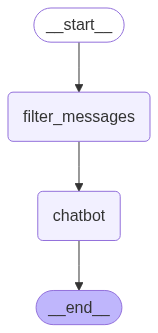

In [10]:
def filter_messages(state: MessagesState):
    updated_messages = [RemoveMessage(m.id) for m in state["messages"][:-2]]
    return { "messages" : updated_messages}
 
def chatbot(state: MessagesState): 
    return {"messages" : [llm.invoke(state["messages"])]}

# building and compiling graph
builder = StateGraph(MessagesState)

builder.add_node("chatbot", chatbot)
builder.add_node("filter_messages", filter_messages)

builder.add_edge(START, "filter_messages")
builder.add_edge("filter_messages", "chatbot")
builder.add_edge("chatbot", END)

graph = builder.compile()

graph

In [11]:
response = graph.invoke({"messages" : messages})

for m in response["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

<think>
Okay, the user mentioned they're researching ocean mammals and already know about whales. Now they want to know others to learn about. Let me think about other major ocean mammals.

First, dolphins are definitely a big one. They're intelligent, part of the cetacean group like whales and porpoises. I should mention their social behavior and communication.

Then there are seals and sea lions. They're pinnipeds, different from each other in some ways, like ear flaps versus external ears. Maybe mention their habitats and how they move on land vs in water.

Sea otters come to mind too. They use tools, which is

Appending the output of the above `AI Message` to the `messages` list to extend the conversation.

In [12]:
messages.append(response["messages"][-1]) 

# Adding a follow-up message to the above conversation
messages.append(HumanMessage("What about dolphins?", name="Lance", id="5"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

<think>
Okay, the user mentioned they're researching ocean mammals and already know about whales. Now they want to know others to learn about. Let me think about other major ocean mammals.

First, dolphins are definitely a big one. They're intelligent, part of the cetacean group like whales and porpoises. I should mention their social behavior and communication.

Then there are seals and sea lions. They're pinnipeds, diffe

## Case 2: Without modifiying Messages data in State 

In this case, instead of modifying the original state we will simply pass the messages list which only we require, to the LLM. 

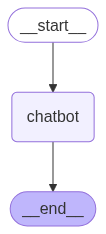

In [13]:
def chatbot(state: MessagesState): 
    return {"messages" : [llm.invoke(state["messages"][-1:])]}

# building and compiling graph
builder = StateGraph(MessagesState)

builder.add_node("chatbot", chatbot)

builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

graph = builder.compile()

graph

In [14]:
response = graph.invoke({"messages" : messages})

for m in response["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

<think>
Okay, the user mentioned they're researching ocean mammals and already know about whales. Now they want to know others to learn about. Let me think about other major ocean mammals.

First, dolphins are definitely a big one. They're intelligent, part of the cetacean group like whales and porpoises. I should mention their social behavior and communication.

Then there are seals and sea lions. They're pinnipeds, diffe

## Trimming Messages 

Unlike filtering messages, Trimming messages as the name mentions it reduces the **number of tokens** in the messages and only those list of messages gets passed into the graph for the inference. 

We can use the in-built module from langchain and we can use the `trim_messages` inside our node. 

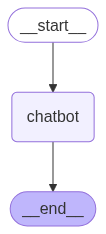

In [15]:
from langchain_core.messages import trim_messages

def chatbot(state: MessagesState): 
    # Trim the messages to 100 tokens
    messages = trim_messages(
        state["messages"], 
        max_tokens=100, 
        strategy="last",  # Keep the last messages
        allow_partial = False,  # Do not allow partial messages
        token_counter =ChatGroq(model="qwen/qwen3-32b")
    )
    
    return {"messages" : [llm.invoke(messages)]}

# building and compiling graph
builder = StateGraph(MessagesState)

builder.add_node("chatbot", chatbot)

builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

graph = builder.compile()

graph

In [17]:
response = graph.invoke({"messages" : messages})

for m in response["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

<think>
Okay, the user mentioned they're researching ocean mammals and already know about whales. Now they want to know others to learn about. Let me think about other major ocean mammals.

First, dolphins are definitely a big one. They're intelligent, part of the cetacean group like whales and porpoises. I should mention their social behavior and communication.

Then there are seals and sea lions. They're pinnipeds, diffe